# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# function to get count for each group
def groupcount(data,sortcol = None):
    '''
    input: 
        data: df[col] or dr.col,dataframe name followed by the column which used to get the group
        sortcol: int, should be 0, 1 or 2, defines which columns used to sort by
    use case: groupcount(df.col1, 0)
    '''
    if data.isnull().sum()>0:
        if data.dtype == 'O':
            data = data.astype(str)
        temp = data.fillna('None').value_counts().reset_index(name='Count')
    else:
        temp = data.value_counts().reset_index(name='Count')
    temp = temp.rename(index=str,columns={'index': 'Group'})
    temp['percent'] = round(temp.Count / temp.Count.sum() *100,1)
    
    if sortcol==1:
        temp = temp.sort_values('Group')
    elif sortcol==2:
        temp = temp.sort_values('Count')
    return temp

# Function to calculate missing values by column# Funct 
# based on the file DIAS Attributes, for majority of features, values of 0 or -1 (some 9) represent unknown
# which is equal to missing in this case. I will replace these with -1 first and use this function to calculate missing rate
def missing_values_table(data):
    import pandas as pd
    import numpy as np
    
    df = data.copy()
    df.replace(to_replace = -1, value = np.nan, inplace = True)

    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    #Calculate how many columns has bigger than 95% missing, save result to table
    BIGmissingN = mis_val_table_ren_columns.loc[mis_val_table_ren_columns['% of Total Values']>95].count()[1]
    
    # Print some summary information
    #  print ("Total columns: " + str(df.shape[1]) + "\n"      
    #      + "Columns that have missing values: " + str(mis_val_table_ren_columns.shape[0]) + "\n"
    #        + 'Missing>95% column number: ' + str(BIGmissingN))
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns


## load data

In [3]:
# load in the data
azdias = pd.read_csv('../data_Arvato/Udacity_AZDIAS_052018.csv')
# customers = pd.read_csv('../data_Arvato/Udacity_CUSTOMERS_052018.csv')

DIAS_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
DIAS_info = DIAS_info.reset_index(drop=True)
ATTR_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
ATTR_info.drop(columns=['Unnamed: 0'], inplace=True)

ATTR_info['Attribute'] = ATTR_info['Attribute'].fillna(method = 'pad')
ATTR_info['Description'] = ATTR_info['Description'].fillna(method = 'pad')
# ATTR_info.head(5)

In [4]:
print('azdias data shape: {0}; customer data shape: {0}'.format(azdias.shape, customers.shape))
print('extra columns for customer data: ', [e for e in customers.columns if e not in azdias.columns])

print(groupcount(customers['PRODUCT_GROUP']))
print(groupcount(customers['CUSTOMER_GROUP']))
print(groupcount(customers['ONLINE_PURCHASE']))

azdias data shape: (891221, 366); customer data shape: (891221, 366)
extra columns for customer data:  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
               Group   Count  percent
0  COSMETIC_AND_FOOD  100860     52.6
1               FOOD   47382     24.7
2           COSMETIC   43410     22.7
          Group   Count  percent
0   MULTI_BUYER  132238     69.0
1  SINGLE_BUYER   59414     31.0
   Group   Count  percent
0      0  174356     91.0
1      1   17296      9.0


Based on the above analysis, we can confirm the three extra columns in customer data, during which we can see 
1. almost half of the customers buy both COSMETIC_AND_FOOD
2. the rest of the customers don't have strong preference between cosmetic and food
3. around 70% of customers are multi-buyer
4. majority of customers are in-store buyers (91%)

based on No.4, my questions is: 
1. does store location plays an important role for target customers?
2. for the 9% online customers, are they far from the store?

## high missing rate features and categorical features

In [58]:
azdias.columns[1]
noinfo_col = [e for e in list(azdias.columns) if e not in list(ATTR_info['Attribute'].apply(lambda x: x.strip()))]
len(noinfo_col)
ATTR_info[ATTR_info['Attribute']==azdias.columns[1]]

'AGER_TYP'

94

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [5]:
# get unknow value for each variable 
UNKN = ATTR_info[ATTR_info['Meaning'].apply(lambda x: 'unknown' in str(x))]
UNKN.shape
UNKN.head()

(233, 4)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [69]:
# go through every line to replace unknown value to -1
len([e for e in azdias.columns if e in list(UNKN['Attribute'])])
# [e for e in list(UNKN['Attribute']) if e not in azdias.columns]
n=0
for e in list(UNKN['Attribute']):
    if e in azdias.columns:
        miss_value = UNKN[UNKN['Attribute']==e]['Value'].values
        if type(miss_value[0]) == str:
            n+=1
            miss_value = [int(x) for x in miss_value[0].split(',')]
            azdias[e] = np.where(azdias[e].isin(miss_value), -1, azdias[e])
print(n, 'values got replaced for unknow')    

225

89 values got replaced for unknow


In [6]:
missing_data = missing_values_table(azdias)
missing_data.head(10)

,Missing Values,% of Total Values
ALTER_KIND4,890016,99.9
ALTER_KIND3,885051,99.3
ALTER_KIND2,861722,96.7
ALTER_KIND1,810163,90.9
AGER_TYP,677503,76.0
EXTSEL992,654153,73.4
KK_KUNDENTYP,584612,65.6
ALTERSKATEGORIE_FEIN,262947,29.5
D19_VERSI_ONLINE_QUOTE_12,257113,28.8
D19_VERSAND_ONLINE_QUOTE_12,257113,28.8


In [12]:
high_miss_col = list(missing_data[missing_data['% of Total Values']>50].index)
high_miss_col

ATTR_info[ATTR_info['Attribute'].isin(high_miss_col)]

['ALTER_KIND4',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP']

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [9]:
# drop high missing columns and convert missing value to Nans
# azdias = azdias[[e for e in azdias.columns if e not in high_miss_col]]
azdias.shape

azdias = azdias.replace(-1, np.nan)


(891221, 359)

In [11]:
azdias.isnull().sum().max()/azdias.shape[0]

0.29504129727643313

In [13]:
# check categorical variables
print(azdias.dtypes.value_counts())
cat_vars = [e for e in azdias.columns if azdias[e].dtypes == 'object']
azdias[cat_vars].head()

float64    264
int64       89
object       6
dtype: int64


,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [15]:
for e in cat_vars:
    print(e, '-- number of unique values:', azdias[e].nunique())

CAMEO_DEU_2015 -- number of unique values: 45
CAMEO_DEUG_2015 -- number of unique values: 19
CAMEO_INTL_2015 -- number of unique values: 43
D19_LETZTER_KAUF_BRANCHE -- number of unique values: 35
EINGEFUEGT_AM -- number of unique values: 5162
OST_WEST_KZ -- number of unique values: 2


In [40]:
DIAS_info[DIAS_info['Attribute'].isin(cat_vars)]
ATTR_info[ATTR_info['Attribute'].isin(cat_vars)].drop_duplicates(subset=['Attribute'])

,Information level,Attribute,Description,Additional notes
83,Building,OST_WEST_KZ,flag indicating the former GDR/FRG,NaN
85,Microcell (RR4_ID),CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,New German CAMEO Typology established together...
86,Microcell (RR4_ID),CAMEO_DEU_2015,CAMEO_4.0: specific group,NaN


,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
61,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
2013,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown


In [17]:
# we will drop EINGEFUEGT_AM as it's time_id and there are too many unique values 
# we will also drop LNR as we already know it's an ID column
azdias = azdias.drop(columns=['EINGEFUEGT_AM', 'LNR'])
cat_vars = [e for e in cat_vars if e != 'EINGEFUEGT_AM']
len(cat_vars)

5

In [32]:
cat_vars

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'OST_WEST_KZ']

In [21]:
# above we know that OST_WEST_KZ only have two unique values, thus can be encoded simply:
azdias['OST_WEST_KZ'].value_counts()
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'W':1.0, 'O':2.0})

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [22]:
# encode other catogorical values
azdias_code = pd.get_dummies(azdias, columns=[e for e in cat_vars if e != 'OST_WEST_KZ'])
azdias_code.shape

(891221, 495)

## impute for missing value

In [62]:
# get numerical value features
num_col = list(ATTR_info[ATTR_info['Meaning'].apply(lambda x: 'numeric' in str(x))]['Attribute'])
num_col

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR']

## combine all previous step to preprocess function 

In [5]:
def preprocess_arvato(df):
    """
    perform preprocess steps for removing high missing columns, re-coding categorical features, extra columns removing
    """
    
    #drop high missing columns and some additional columns:
    high_miss_col = ['ALTER_KIND4',
                     'ALTER_KIND3',
                     'ALTER_KIND2',
                     'ALTER_KIND1',
                     'AGER_TYP',
                     'EXTSEL992',
                     'KK_KUNDENTYP']
    other_drop_col = ['LNR', 'EINGEFUEGT_AM']
    drops = high_miss_col + other_drop_col
    
    df1 = df[[e for e in df.columns if e not in drops ]]
    
    # special encoding for OST_WEST_KZ
    df1['OST_WEST_KZ'] = df1['OST_WEST_KZ'].replace({'W':1.0, 'O':2.0})
    
    # encode other catogorical values
    cat_vars = ['CAMEO_DEU_2015',
                 'CAMEO_DEUG_2015',
                 'CAMEO_INTL_2015',
                 'D19_LETZTER_KAUF_BRANCHE']
    df1 = pd.get_dummies(df1, columns=cat_vars)
     
    return df1

In [158]:
azdias_pp = preprocess_arvato(azdias)

In [37]:
azdias_pp.shape == azdias_code.shape

True

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In order to do some customer segmentation, these steps will be run:
1. preprocess using the above funcion
2. impute missing value with mean
3. feature scalling 

In [2]:
azdias = pd.read_csv('../data_Arvato/Udacity_AZDIAS_052018.csv')

In [3]:
imputer = Imputer(missing_values='NaN',strategy='mean')
scaler = StandardScaler()

azdias_pp = preprocess_arvato(azdias)
azdias_imp = imputer.fit_transform(azdias_pp)
azdias_sca = scaler.fit_transform(azdias_imp)

In [103]:
del azdias_pp, azdias_imp, azdias_code

## PCA analysis

Dimensional reduction is one of the most popular way of displaying higher number of dimensions, and priciple component analysis is the most usual method for dimension reduction

In [103]:
# try PCA with 100 dimension
pca = PCA(n_components=300)
azdias_pca = pca.fit_transform(azdias_sca)
print(azdias_pca.shape)

(891221, 300)


### PCA Model Attributes

Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
    
We are only interested in v and s. 

total explained variance:  0.9519853386987012
top 150 components explained variance:  0.7568318605451128


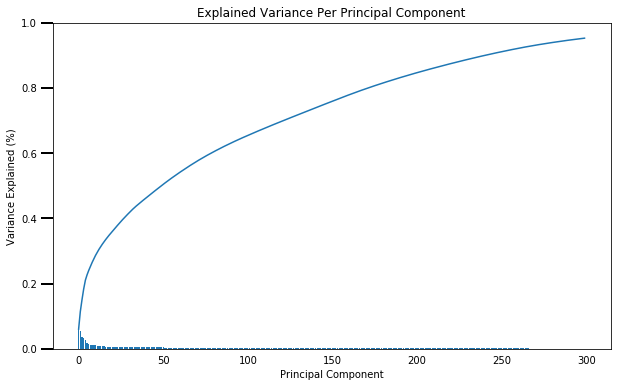

In [17]:
# check the percent of variance explained by each principal component.
InteractiveShell.ast_node_interactivity = "last_expr"

print('total explained variance: ',sum(pca.explained_variance_ratio_))
print('top 150 components explained variance: ',sum(pca.explained_variance_ratio_[0:150]))

ind = np.arange(300)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
ax = plt.subplot()
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(300):
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component');

### Pinciple Components Interpretation

In [20]:
pca.components_.shape

(300, 495)

In [28]:
# Map weights for the first principal component to corresponding feature names

dimensions = ['CP{}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
PCA_CP = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_pp.columns).T
PCA_CP.columns = dimensions
components.head(3)

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP291,CP292,CP293,CP294,CP295,CP296,CP297,CP298,CP299,CP300
AKT_DAT_KL,0.0688,-0.0050,-0.0189,0.0067,-0.0926,0.0182,0.0141,0.0108,-0.0514,-0.0143,...,0.0232,-0.0627,0.0036,-0.0347,-0.0547,-0.0242,0.0406,-0.0806,-0.0013,-0.0437
ALTER_HH,-0.0533,-0.0104,0.0861,0.0022,-0.0296,0.0055,-0.0028,0.0110,-0.0058,0.0072,...,0.0052,0.0363,0.0313,0.0554,0.0559,-0.0385,-0.0015,0.0140,0.0094,0.0280
ALTERSKATEGORIE_FEIN,-0.0047,-0.0191,0.1029,0.0097,-0.1364,0.0317,0.0021,0.0230,-0.0287,-0.0146,...,0.0380,0.0061,-0.0755,0.0381,0.0393,0.0185,-0.0401,0.2244,-0.0324,0.0855


In [46]:
DIAS_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
DIAS_info = DIAS_info.reset_index(drop=True)

In [58]:
# aggregate the top 3 and bottom 3 features for first 3 components 
mycp = pd.concat([pd.concat([pd.DataFrame(PCA_CP['CP1'].sort_values(ascending=False)[:3]),
                    pd.DataFrame(PCA_CP['CP1'].sort_values(ascending=False)[-3:])]).reset_index(),
                    pd.concat([pd.DataFrame(PCA_CP['CP2'].sort_values(ascending=False)[:3]),
                                pd.DataFrame(PCA_CP['CP2'].sort_values(ascending=False)[-3:])]).reset_index(),
                    pd.concat([pd.DataFrame(PCA_CP['CP3'].sort_values(ascending=False)[:3]),
                                pd.DataFrame(PCA_CP['CP3'].sort_values(ascending=False)[-3:])]).reset_index()],axis=1)
mycp.columns = ['CP1_feature', 'CP1','CP2_feature', 'CP2','CP3_feature', 'CP3']
mycp

,CP1_feature,CP1,CP2_feature,CP2,CP3_feature,CP3
0,PLZ8_ANTG3,0.1229,KBA05_SEG6,0.1780,D19_GESAMT_ANZ_24,0.1519
1,KBA13_ANTG3,0.1228,KBA05_KRSOBER,0.1630,ONLINE_AFFINITAET,0.1434
2,KBA13_ANTG4,0.1203,KBA05_KRSVAN,0.1605,D19_GESAMT_ANZ_12,0.1432
3,KBA13_ANTG1,-0.1235,PLZ8_ANTG3,-0.0367,D19_VERSAND_ONLINE_DATUM,-0.1427
4,PLZ8_ANTG1,-0.1238,KBA13_ANTG3,-0.0367,D19_GESAMT_DATUM,-0.1435
5,MOBI_REGIO,-0.1289,KBA05_ANTG3,-0.0392,D19_GESAMT_ONLINE_DATUM,-0.1480


In [59]:
# merge with information data to see the definition for each feature
CP1_info = DIAS_info[DIAS_info['Attribute'].isin(mycp['CP1_feature'])][['Attribute', 'Description']]
CP2_info = DIAS_info[DIAS_info['Attribute'].isin(mycp['CP2_feature'])][['Attribute', 'Description']]
CP3_info = DIAS_info[DIAS_info['Attribute'].isin(mycp['CP3_feature'])][['Attribute', 'Description']]
mycp = pd.merge(mycp, CP1_info, how='left', 
                left_on='CP1_feature', 
                right_on='Attribute').drop(columns=['Attribute']).rename(columns={'Description':'CP1_def'})
mycp = pd.merge(mycp, CP2_info, how='left',
                left_on='CP2_feature',
                right_on='Attribute').drop(columns=['Attribute']).rename(columns={'Description':'CP2_def'})
mycp = pd.merge(mycp, CP3_info, how='left', 
                left_on='CP3_feature', 
                right_on='Attribute').drop(columns=['Attribute']).rename(columns={'Description':'CP3_def'})
mycp = mycp[sorted(mycp.columns)]
mycp

,CP1,CP1_def,CP1_feature,CP2,CP2_def,CP2_feature,CP3,CP3_def,CP3_feature
0,0.1229,number of 6-10 family houses in the PLZ8,PLZ8_ANTG3,0.1780,share of upper class cars (BMW 7er etc.) in th...,KBA05_SEG6,0.1519,NaN,D19_GESAMT_ANZ_24
1,0.1228,NaN,KBA13_ANTG3,0.1630,share of upper class cars (referred to the cou...,KBA05_KRSOBER,0.1434,online affinity,ONLINE_AFFINITAET
2,0.1203,NaN,KBA13_ANTG4,0.1605,share of vans (referred to the county average),KBA05_KRSVAN,0.1432,NaN,D19_GESAMT_ANZ_12
3,-0.1235,NaN,KBA13_ANTG1,-0.0367,number of 6-10 family houses in the PLZ8,PLZ8_ANTG3,-0.1427,actuality of the last transaction for the segm...,D19_VERSAND_ONLINE_DATUM
4,-0.1238,number of 1-2 family houses in the PLZ8,PLZ8_ANTG1,-0.0367,NaN,KBA13_ANTG3,-0.1435,actuality of the last transaction with the com...,D19_GESAMT_DATUM
5,-0.1289,moving patterns,MOBI_REGIO,-0.0392,number of 6-10 family houses in the cell,KBA05_ANTG3,-0.1480,actuality of the last transaction with the com...,D19_GESAMT_ONLINE_DATUM


* **discussions for top 3 dimension important features**

* **first dimension**:  <br>
    PLZ8_ANTG3 0.1229: number of 6-10 family houses in the PLZ8<br>
    KBA13_ANTG3 0.1228: nan<br>
    KBA13_ANTG4 0.1203: nan<br>
    KBA13_ANTG1 -0.1235: nan<br>
    PLZ8_ANTG1 -0.1238: number of 1-2 family houses in the PLZ8<br>
    MOBI_REGIO -0.1289: moving patterns<br>
* **second dimension**: <br>
    KBA05_SEG6 0.178: share of upper class cars (BMW 7er etc.) in the microcell<br>
    KBA05_KRSOBER 0.163: share of upper class cars (referred to the county average)<br>
    KBA05_KRSVAN 0.1605: share of vans (referred to the county average)<br>
    PLZ8_ANTG3 -0.0367: number of 6-10 family houses in the PLZ8<br>
    KBA13_ANTG3 -0.0367: nan<br>
    KBA05_ANTG3 -0.0392: number of 6-10 family houses in the cell<br>
* **third dimension**:<br>
    D19_GESAMT_ANZ_24 0.1519 nan<br>
    ONLINE_AFFINITAET 0.1434 online affinity<br>
    D19_GESAMT_ANZ_12 0.1432 nan<br>
    D19_VERSAND_ONLINE_DATUM -0.1427: actuality of the last transaction for the segment mail-order ONLINE<br>
    D19_GESAMT_DATUM -0.1435: actuality of the last transaction with the complete file TOTAL<br>
    D19_GESAMT_ONLINE_DATUM -0.148: actuality of the last transaction with the complete file ONLINE<br>

## K-means analysis

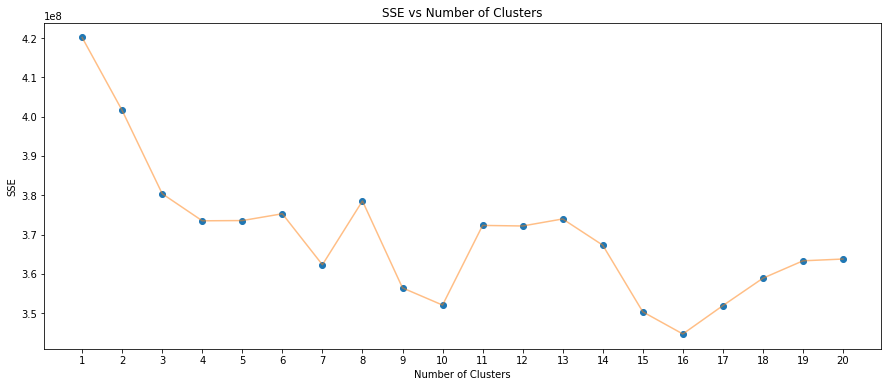

In [91]:
# use elbow method to determin what's the number of clusters would be appropriate for our sample

scores= []
for n in range(1 , 21):
    # run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(n_clusters=n, random_state=2020)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(azdias_pca))
    scores.append(score)

plt.figure(1 , figsize = (15 ,6))
ax=plt.subplot()
plt.plot(np.arange(1 , 21) , scores , 'o')
plt.plot(np.arange(1 , 21) , scores , '-' , alpha = 0.5)
plt.xticks(np.arange(1, 21, step=1))
plt.xlabel('Number of Clusters') , plt.ylabel('SSE'), plt.title('SSE vs Number of Clusters');

**discussion:**

    it seems that 16 cluster gives smallest SSE

In [92]:
# refit with 16 clusters and get prediction for whole data
# Kmeans gives me out of memory error, so I just tried with MiniBatchKmeans
kmeans = MiniBatchKMeans(n_clusters=16, random_state=2020)
kmeans.fit(azdias_pca)
azdias_preds = kmeans.labels_
centroids = kmeans.cluster_centers_

In [93]:
import pickle
pickle.dump(kmeans, open('./minibatchkmeans.bin', 'wb'))

In [104]:
# centroids.shape  #(16, 495)
# len(azdias_preds) # 891221
# PCA_CP.shape #(495, 300)
azdias_cluster = pd.DataFrame(np.round(azdias_pca, 4), columns = dimensions)
azdias_cluster['cluster'] = azdias_preds
general_cluster_count = groupcount(azdias_cluster['cluster'])
general_cluster_count.head(5)

,Group,Count,percent
0,5,165963,18.6
1,8,158383,17.8
2,14,141584,15.9
3,2,135083,15.2
4,9,74423,8.4


## segment Customer data

In [75]:
# customers = pd.read_csv('../data_Arvato/Udacity_CUSTOMERS_052018.csv')
print(customers.shape)
customers.head(2)

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4


In [83]:
[e for e in customers.columns if e not in azdias.columns]

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

In [85]:
customers1 = customers.drop(columns=['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'])
customers1.shape

(191652, 366)

In [107]:
# same as azdias data, apply same steps to customers data
imputer = Imputer(missing_values='NaN',strategy='mean')
scaler = StandardScaler()

cust_pp = preprocess_arvato(customers1)
cust_imp = imputer.fit_transform(cust_pp)
cust_sca = scaler.fit_transform(cust_imp)
cust_pca = pca.transform(cust_sca)
cust_preds = kmeans.predict(cust_pca)

In [121]:
cust_cluster = pd.DataFrame(np.round(cust_pca, 4), columns = dimensions)
cust_cluster['cluster'] = cust_preds
cust_cluster_count = groupcount(cust_cluster['cluster'])
cust_cluster_count.head(5)

,Group,Count,percent
0,5,38645,20.2
1,10,36991,19.3
2,8,35572,18.6
3,9,22158,11.6
4,14,19281,10.1


Text(0,0.5,'Cluster')

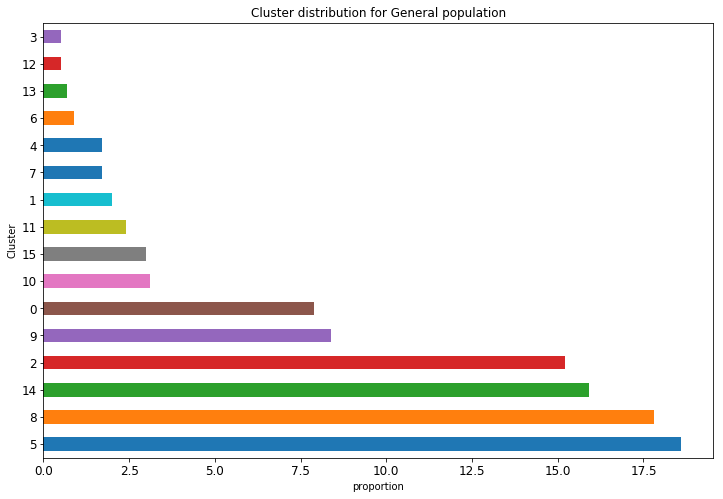

In [125]:
ax = general_cluster_count.plot(kind='barh', x='Group', y='percent',
                                title ="Cluster distribution for General population",
                                figsize=(12, 8), 
                                legend=False,
                                fontsize=12)
plt.xlabel('proportion')
plt.ylabel('Cluster')

Text(0,0.5,'Cluster')

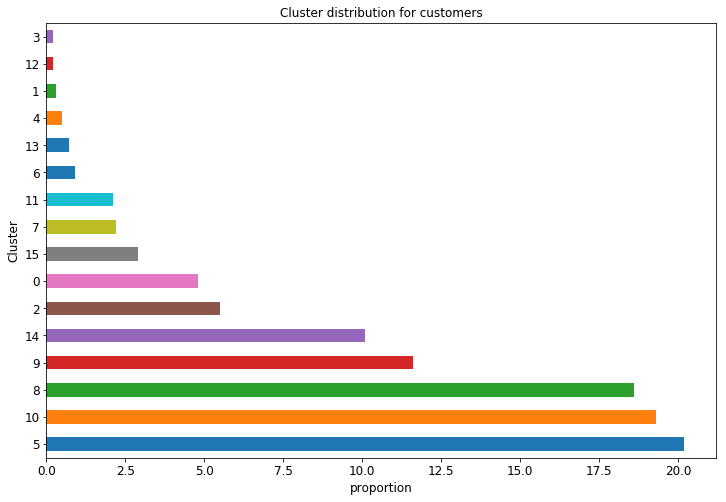

In [138]:
ax = cust_cluster_count.plot(kind='barh', x='Group', y='percent',
                                title ="Cluster distribution for customers",
                                figsize=(12, 8), 
                                legend=False,
                                fontsize=12);
plt.xlabel('proportion',fontsize=12)
plt.ylabel('Cluster',fontsize=12)

In [130]:
cluster_diff = pd.merge(general_cluster_count,cust_cluster_count, how='left', on = 'Group',suffixes=['_general','_customer'])
cluster_diff['diff'] = cluster_diff['percent_customer'] - cluster_diff['percent_general']
cluster_diff.head()

,Group,Count_general,percent_general,Count_customer,percent_customer,diff
0,5,165963,18.6,38645,20.2,1.6
1,8,158383,17.8,35572,18.6,0.8
2,14,141584,15.9,19281,10.1,-5.8
3,2,135083,15.2,10548,5.5,-9.7
4,9,74423,8.4,22158,11.6,3.2


Text(0,0.5,'Cluster')

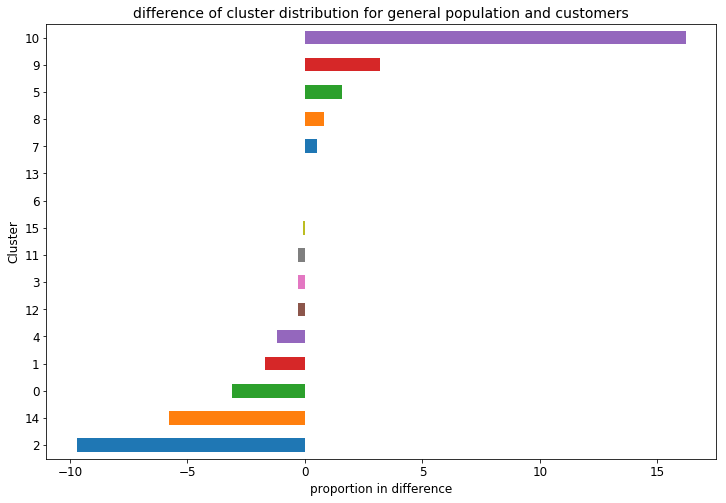

In [137]:
ax = cluster_diff.sort_values(by=['diff']).plot(kind='barh', x='Group', y='diff',
                                figsize=(12, 8), 
                                legend=False,
                                fontsize=12);
plt.title("difference of cluster distribution for general population and customers",fontsize=14)
plt.xlabel('proportion in difference',fontsize=12)
plt.ylabel('Cluster',fontsize=12)

* **discussion for comparing customer data and general population cluster difference:**<br>
* In Customer group, cluster 10 has around 16% more and cluster 2 has around 10% less compared to the distribution in general population <br>
* we can take a look into the data classified as cluster 10 and cluster 2, and compare some key features identified by PCA above to see if there is any pattern<br>

In [150]:
# features in interest based on PCA top 2 components analysis
interest_fet = list(set(list(mycp['CP1_feature']) + list(mycp['CP2_feature'])))
len(interest_fet)

10

In [143]:
# get the over group (cluster10) and under group (cluster2)
customers1['cluster'] = cust_preds
cust_over = customers1[customers1['cluster']==10]
cust_under = customers1[customers1['cluster']==2]
print(cust_over.shape, cust_under.shape)

(36991, 367) (10548, 367)


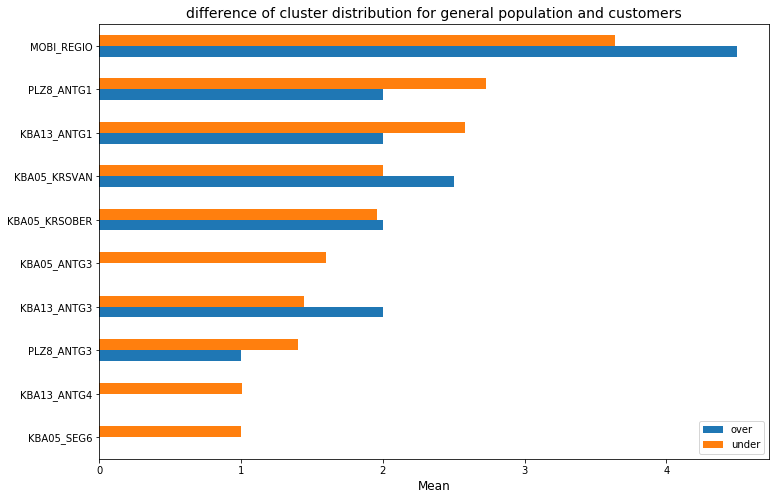

In [154]:
temp = pd.DataFrame(index=interest_fet, columns=['over','under'])
for e in interest_fet:
    temp.at[e,'over'] = cust_over[cust_over[e]>0][e].mean()
    temp.at[e,'under'] = cust_under[cust_under[e]>0][e].mean()
# temp

# Plot the means of the interested features for the over and under represented groups
fig, ax = plt.subplots(figsize=(12,8))
plt.title("difference of cluster distribution for general population and customers",fontsize=14)
plt.xlabel('Mean',fontsize=12)
temp.sort_values(by=['under']).plot.barh(ax=ax);

Based on this comparison, the over represented group tends to have:
    * higher MOBI_REGIO: lower moving activities
    * lower PLZ8_ANTG1: lower number of 1-2 family houses in the PLZ8
    * higher KBA05_KRSVAN: higher share of vans
    * lower PLZ8_ANTG3: lower number of 6-10 family houses in the PLZ8
    * lower KBA05_ANTG3: lower number of 6-10 family houses in the cell
    * lower KBA05_SEG6: lower share of upper class cars (BMW 7er etc.) in the microcell
    
So in general, the over represented group tends to have these charactristict:
* less moving activities
* drive vans more often, not upper class cars

In [155]:
print(cust_over[cust_over['PLZ8_ANTG2']>0]['PLZ8_ANTG2'].mean(),cust_under[cust_under['PLZ8_ANTG2']>0]['PLZ8_ANTG2'].mean())
print(cust_over[cust_over['PLZ8_ANTG4']>0]['PLZ8_ANTG4'].mean(),cust_under[cust_under['PLZ8_ANTG4']>0]['PLZ8_ANTG4'].mean())

2.0 2.628031145717464
nan 1.0042708968883465


# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [6]:
# import extra libraries
# from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBRegressor, XGBClassifier
import lightgbm as lgb

def preprocess_arvato(df):
    """
    perform preprocess steps for removing high missing columns, re-coding categorical features, extra columns removing
    """
    
    #drop high missing columns and some additional columns:
    high_miss_col = ['ALTER_KIND4',
                     'ALTER_KIND3',
                     'ALTER_KIND2',
                     'ALTER_KIND1',
                     'AGER_TYP',
                     'EXTSEL992',
                     'KK_KUNDENTYP']
    other_drop_col = ['LNR', 'EINGEFUEGT_AM']
    drops = high_miss_col + other_drop_col
    
    df1 = df[[e for e in df.columns if e not in drops ]]
    
    # special encoding for OST_WEST_KZ
    df1['OST_WEST_KZ'] = df1['OST_WEST_KZ'].replace({'W':1.0, 'O':2.0})
    
    # encode other catogorical values
    cat_vars = ['CAMEO_DEU_2015',
                 'CAMEO_DEUG_2015',
                 'CAMEO_INTL_2015',
                 'D19_LETZTER_KAUF_BRANCHE']
    df1 = pd.get_dummies(df1, columns=cat_vars)
     
    return df1

In [5]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
Train = pd.read_csv('../data_Arvato/Udacity_MAILOUT_052018_TRAIN.csv')
print(Train.shape)
Train.head(3)

(42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4


In [7]:
groupcount(Train['RESPONSE'])

,Group,Count,percent
0,0,42430,98.8
1,1,532,1.2


* **532 out of 42962 in training data is customer (1.2%)**
* Due to the fact of imbalance, we can try with over sampling method to see if it can improve model performance
* For such imbalance data, we will use ROC-AUC to evaluate model performance

In [8]:
# preprocess the Train data
Train_pp = preprocess_arvato(Train)
print(Train.shape, Train_pp.shape)

# split Train to features and target
y = Train_pp['RESPONSE']
X = Train_pp.drop(columns=['RESPONSE'])
print(X.shape)

(42962, 367) (42962, 496)
(42962, 495)


**Model Training and parameter tuning:**<br>
* we will use GridSearchCV for parameter tuning, which could reduce overfitting 
* we will mainly use lightGBM as our target model, for saving time and higher efficacy
    

In [9]:
# Tanks to CASPER HANSEN, https://mlfromscratch.com/gridsearch-keras-sklearn/#/
def algorithm_pipeline(X_train_data, y_train_data,
                       model, param_grid, cv=5, 
                       scoring_fit='neg_mean_squared_error'):
    from sklearn.model_selection import GridSearchCV
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2,
        return_train_score='True'
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
       
    return fitted_model

In [206]:
################### for lightGBM ##################
param_grid = {
    'n_estimators': [700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [3,4,5],
    'num_leaves': [100],
    'reg_alpha': [1.1],
    'reg_lambda': [1.1],
    'min_split_gain': [0.4],
    'subsample': [0.8],
    'subsample_freq': [20]
}

model = algorithm_pipeline(X, y, lgb.LGBMClassifier(),
                            param_grid, cv=5, 
                           scoring_fit='roc_auc')

print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.4min finished


0.7252837795866545
{'colsample_bytree': 0.8, 'max_depth': 25, 'min_split_gain': 0.4, 'n_estimators': 700, 'num_leaves': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.8, 'subsample_freq': 20}


In [209]:
param_grid = {
    'n_estimators': [500,700],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [2,3,4],
    'num_leaves': [100],
    'reg_alpha': [1.1],
    'reg_lambda': [1.1],
    'min_split_gain': [0.4],
    'subsample': [0.8],
    'subsample_freq': [20]
}

model = algorithm_pipeline(X, y, lgb.LGBMClassifier(),
                            param_grid, cv=5, 
                           scoring_fit='roc_auc')

print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.7min finished


0.7568929277839679
{'colsample_bytree': 0.7, 'max_depth': 2, 'min_split_gain': 0.4, 'n_estimators': 500, 'num_leaves': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.8, 'subsample_freq': 20}


In [210]:
param_grid = {
    'n_estimators': [300,500],
    'colsample_bytree': [0.7],
    'max_depth': [2],
    'num_leaves': [100],
    'reg_alpha': [1.1,1.3],
    'reg_lambda': [1.1,1.3],
    'min_split_gain': [0.4],
    'subsample': [0.8],
    'subsample_freq': [20]
}

model1 = algorithm_pipeline(X, y, lgb.LGBMClassifier(),
                            param_grid, cv=5, 
                           scoring_fit='roc_auc')

print(model1.best_score_)
print(model1.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.4min finished


0.7596945071380635
{'colsample_bytree': 0.7, 'max_depth': 2, 'min_split_gain': 0.4, 'n_estimators': 300, 'num_leaves': 100, 'reg_alpha': 1.3, 'reg_lambda': 1.3, 'subsample': 0.8, 'subsample_freq': 20}


In [211]:
param_grid = {
    'n_estimators': [200,300],
    'colsample_bytree': [0.7],
    'max_depth': [2],
    'num_leaves': [100],
    'reg_alpha': [1.3,1.5],
    'reg_lambda': [1.3,1.5],
    'min_split_gain': [0.3,0.4,0.5],
    'subsample': [0.8],
    'subsample_freq': [20]
}

model2 = algorithm_pipeline(X, y, lgb.LGBMClassifier(),
                            param_grid, cv=5, 
                           scoring_fit='roc_auc')

print(model2.best_score_)
print(model2.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 11.2min finished


0.7667465660055132
{'colsample_bytree': 0.7, 'max_depth': 2, 'min_split_gain': 0.4, 'n_estimators': 200, 'num_leaves': 100, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.8, 'subsample_freq': 20}


In [212]:
param_grid = {
    'n_estimators': [200],
    'colsample_bytree': [0.7],
    'max_depth': [2],
    'num_leaves': [100],
    'reg_alpha': [1.5,1.6],
    'reg_lambda': [1.5,1.6],
    'min_split_gain': [0.4,0.6],
    'subsample': [0.6,0.7,0.8],
    'subsample_freq': [20]
}

model3 = algorithm_pipeline(X, y, lgb.LGBMClassifier(),
                            param_grid, cv=5, 
                           scoring_fit='roc_auc')

print(model3.best_score_)
print(model3.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.1min finished


0.7667465660055132
{'colsample_bytree': 0.7, 'max_depth': 2, 'min_split_gain': 0.4, 'n_estimators': 200, 'num_leaves': 100, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.8, 'subsample_freq': 20}


In [213]:
param_grid = {
    'learning_rate':[0.01],
    'n_estimators': [200],
    'colsample_bytree': [0.7],
    'max_depth': [2],
    'num_leaves': [80,100],
    'min_data_in_leaf':[20,30],
    'reg_alpha': [1.5],
    'reg_lambda': [1.5],
    'min_split_gain': [0.4],
    'subsample': [0.8],
    'subsample_freq': [20]
}

model4 = algorithm_pipeline(X, y, lgb.LGBMClassifier(),
                            param_grid, cv=5, 
                           scoring_fit='roc_auc')

print(model4.best_score_)
print(model4.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished


0.7681747184084001
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'min_data_in_leaf': 20, 'min_split_gain': 0.4, 'n_estimators': 200, 'num_leaves': 80, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.8, 'subsample_freq': 20}


In [11]:
param_grid = {
    'learning_rate':[0.01],
    'n_estimators': [200],
    'colsample_bytree': [0.7],
    'max_depth': [3],
    'num_leaves': [80],
    'min_data_in_leaf':[10],
    'reg_alpha': [1.5],
    'reg_lambda': [1.5],
    'min_split_gain': [0.4],
    'subsample': [0.8],
    'subsample_freq': [20]
}

model4 = algorithm_pipeline(X, y, lgb.LGBMClassifier(),
                            param_grid, cv=5, 
                           scoring_fit='roc_auc')

print(model4.best_score_)
print(model4.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.7s finished


0.7710440037523637
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_data_in_leaf': 10, 'min_split_gain': 0.4, 'n_estimators': 200, 'num_leaves': 80, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.8, 'subsample_freq': 20}


In [17]:
model4.best_estimator_.booster_.save_model('bestlgb.txt')

In [18]:
# best_param = {'colsample_bytree': 0.7, 'learning_rate': 0.01, 
#               'max_depth': 3, 'min_data_in_leaf': 10, 
#               'min_split_gain': 0.4, 'n_estimators': 200,
#               'num_leaves': 80, 'reg_alpha': 1.5, 'reg_lambda': 1.5,
#               'subsample': 0.8, 'subsample_freq': 20}

final_model = lgb.Booster(model_file='bestlgb.txt')

y_pred = final_model.predict(X)

print('ROC-AUC for whole training dataset:',roc_auc_score(y.values,y_pred))

ROC-AUC for whole training dataset: 0.8272660720266374


In [248]:
# roc-auc for whole training data set
print('ROC-AUC for whole training dataset:',roc_auc_score(y.values,model4.best_estimator_.predict_proba(X)[:,1]))

ROC-AUC for whole training dataset: 0.8272660720266374


In [215]:
def feature_plot(importances, X_train, y_train, num_feat=5):
     
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:num_feat]]
    values = importances[indices][:num_feat]
 
    # Create the plot
    fig = plt.figure(figsize = (16,9))
    plt.title("Normalized Weights for the Most Predictive Features", fontsize = 16)
    plt.barh(np.arange(num_feat), values[::-1], height = 0.6, align="center", \
          label = "Feature Weight")
    plt.barh(np.arange(num_feat) - 0.3, np.cumsum(values)[::-1], height = 0.2, align = "center", \
          label = "Cumulative Feature Weight")
    plt.yticks(np.arange(num_feat), columns[::-1])
    plt.xlabel("Weight", fontsize = 12)
    plt.ylabel('')
     
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()

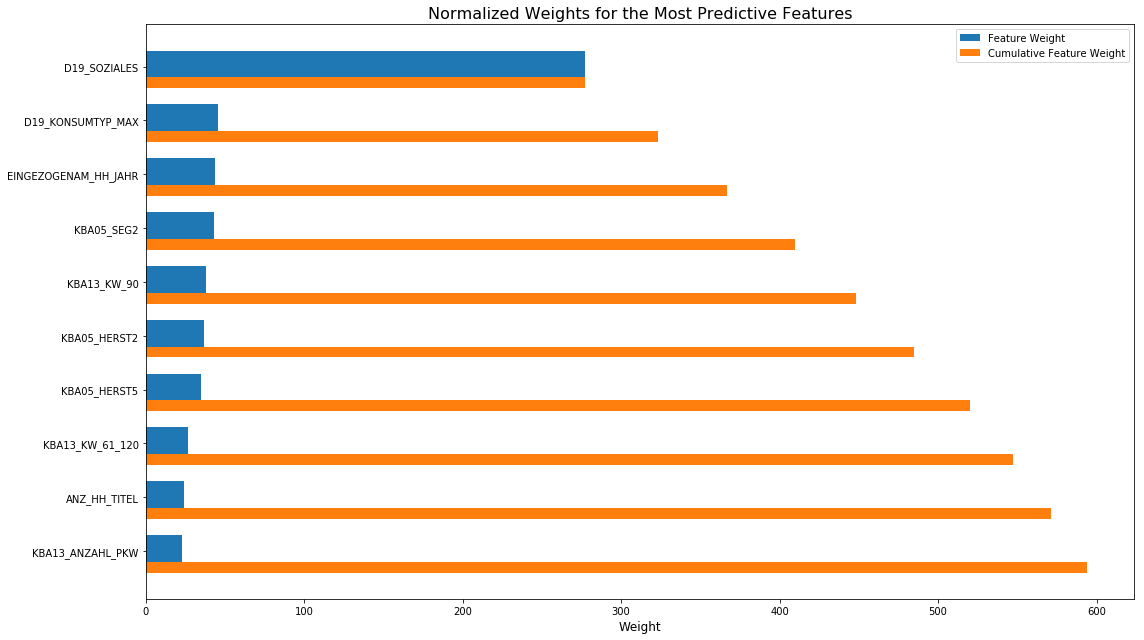

In [245]:
importances = model4.best_estimator_.feature_importances_

feature_plot(importances, X, y, 10)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [228]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
Test = pd.read_csv('../data_Arvato/Udacity_MAILOUT_052018_TEST.csv')
print(Test.shape)
Test.head(3)

(42833, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4


In [229]:
Test_pp = preprocess_arvato(Test)
print(Test.shape, Test_pp.shape)

(42833, 366) (42833, 495)


In [230]:
test_pred = model4.best_estimator_.predict_proba(Test_pp)[:,1]
test_pred[0:5]

array([0.03212408, 0.03220892, 0.00451184, 0.00528767, 0.00629468])

In [246]:
submission = pd.DataFrame()
submission['LNR'] = Test['LNR']
submission['RESPONSE'] = test_pred
submission.set_index('LNR',inplace=True)
submission.head()

,RESPONSE
LNR,
1754,0.032124
1770,0.032209
1465,0.004512
1470,0.005288
1478,0.006295


In [247]:
submission.to_csv('submission.csv')